In [2]:
import diffrax

For scientific computing and simulation, Diffrax is much faster than `torchdiffeq`. It is actively maintained by Kidger. It has the following features:
- ODE, SDE, CDE solvers
- Higher order, implicit, symplectic solver 
- Save at time points, save dense solutions
- Multiple Methods for backprop 
- Adaptive step size controllers 
- Event Handling, Discontinuities 
- Distributed computing with GPU/TPU support 
- Composability with rest of JAX ecosystem 

Diffrax has autodiff also and loads more featuers. 

Under the hood, ODEs and SDEs are unified as CDEs, 

$$
\begin{aligned}
 & dy(t) = f(t,y(t))dt  && ODE \\
 & dy(t) = f_1(t,y(t))dt + f_2(t,y(t))dw(t) && SDE \\ 
 & dy(t) = f(t,y(t))dx(t) && CDE 
\end{aligned}
$$

Euler methods:
$$
\begin{aligned}
 & y_{n+1} = y_n + f(t_n,y_n)(t_{n+1}-t_n)\\
 & y_{n+1} = y_n + f_1(t_n, y_n)(t_{n+1}-t_n) + f_2(t_n, y_n)(w(t_{n+1})-w(t_n)))
\end{aligned}
$$

THe terms are vector fiell, control, and bilinear interaction between them. 
- `diffrax.ControlTerm`, `diffrax.ODETerm`, etc. 


In [10]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

In [13]:
import jax.numpy as jnp
import numpy as np

t0, t1 = 0, 3
dt0=0.05
ts =np.linspace(t0,t1,20)
vector_field = lambda t, y, args: -y
term = ODETerm(vector_field)
solver = Dopri5()
saveat = SaveAt(ts=ts)
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=1, saveat=saveat,
                  stepsize_controller=stepsize_controller)

Text(0.5, 1.0, 'trajectory')

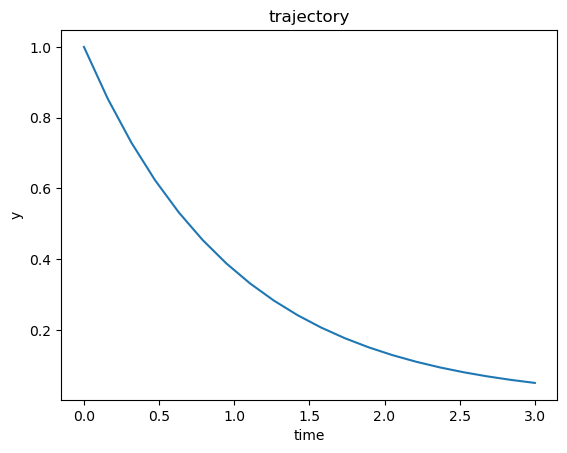

In [14]:
import matplotlib.pyplot as plt
plt.plot(sol.ts, sol.ys)
plt.xlabel("time")
plt.ylabel("y")
plt.title("trajectory")

In [15]:
import jax.random as jr 
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm,ODETerm, SaveAt, VirtualBrownianTree

t0, t1 = 1, 3

drift = lambda t, y, args: -y # drift term 
diffusion = lambda t, y, args: 0.1 * t  # diffusion term 
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(0))
terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=1.0, saveat=saveat)
print(sol.evaluate(1.1))  # DeviceArray(0.89436394)

0.96505475


In [20]:
ts = np.linspace(t0,t1,30)
ys = [sol.evaluate(t) for t in ts]

Text(0.5, 1.0, 'SDE trajectory')

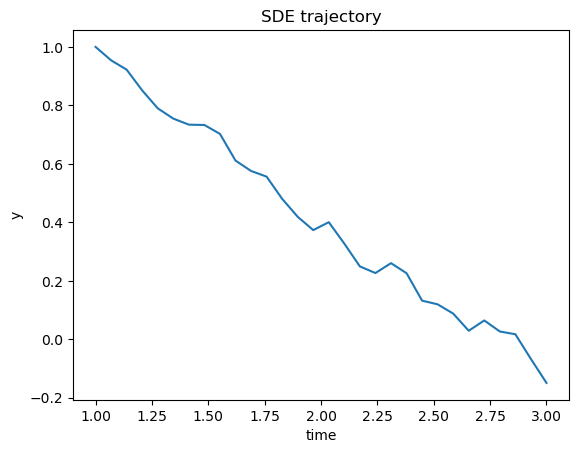

In [22]:
import matplotlib.pyplot as plt
plt.plot(ts, ys)
plt.xlabel("time")
plt.ylabel("y")
plt.title("SDE trajectory")

Text(0.5, 1.0, 'trajectory for CDE')

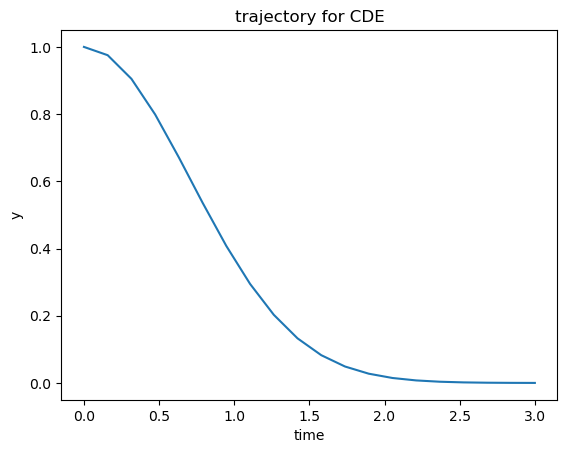

In [26]:
from diffrax import AbstractPath, ControlTerm, diffeqsolve, Dopri5

# specify a control by diffrax.AbstractPath 
# usually requires an interpolation scheme from dataset
class QuadraticPath(AbstractPath):
    @property
    def t0(self):
        return 0

    @property
    def t1(self):
        return 3

    def evaluate(self, t0, t1=None, left=True):
        del left
        if t1 is not None:
            return self.evaluate(t1) - self.evaluate(t0)
        return t0 ** 2
    
vector_field = lambda t, y, args: -y
control = QuadraticPath()
term = ControlTerm(vector_field, control).to_ode()
solver = Dopri5()
# saveat = SaveAt(dense=True)
ts = np.linspace(0,3,20)
saveat = SaveAt(ts=ts)

sol = diffeqsolve(term, solver, t0=0, t1=3, dt0=0.05, y0=1,saveat=saveat)

plt.plot(sol.ts, sol.ys)
plt.xlabel("time")
plt.ylabel("y")
plt.title("trajectory for CDE")